# Training

This notebook is to train the model on the images from **all vidoes**. That is, no videos are reserved for validation/test purposes. Instead, images from all vidoes are mixed, and then randomly select 25% of the images as validation set.

I tried it only using Transfer Learning based on VGG16 model. All conv layers from VGG are kept. The last conv layer is flattened and fully-connected to a prediction layer (2 outputs, softmax activation). Loss function is cross entrophty.

Ran it a few times. The accuracy ended up around 94%. 

In [3]:
from keras import applications
from keras.preprocessing.image import ImageDataGenerator
from keras import optimizers
from keras.models import Sequential, Model 
from keras.layers import Dropout, Flatten, Dense, GlobalAveragePooling2D, Activation
from keras import backend as k 
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, TensorBoard, EarlyStopping, ReduceLROnPlateau

img_width, img_height = 224,224
train_data_dir = "/data/generated/train-all-videos"
validation_data_dir = "/data/generated/val-all-videos"
batch_size = 16
epochs = 1000

model = applications.VGG19(include_top=False, weights='imagenet', input_shape = (img_width, img_height, 3))

for layer in model.layers:
    layer.trainable = False

#Adding custom Layers 
x = model.output
x = Flatten()(x)
x = Dropout(0.5)(x)
predictions = Dense(2, activation="softmax")(x)

# creating the final model 
model_final = Model(inputs = model.input, outputs = predictions)

# compile the model 

model_final.compile(loss='categorical_crossentropy', optimizer = optimizers.Adam(lr=0.0002), metrics=["accuracy"])
#               optimizer='rmsprop',
#               metrics=['accuracy'])

model_final.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

In [2]:
train_datagen = ImageDataGenerator(
rescale = 1./255,
horizontal_flip = True,
vertical_flip = True,
fill_mode = "nearest",
zoom_range = 0.3,
width_shift_range = 0.3,
height_shift_range=0.3,
rotation_range=30)

test_datagen = ImageDataGenerator(
rescale = 1./255)

train_generator = train_datagen.flow_from_directory(
train_data_dir,
target_size = (img_height, img_width),
batch_size = batch_size,
shuffle=True,
class_mode = "categorical")

validation_generator = test_datagen.flow_from_directory(
validation_data_dir,
batch_size = batch_size,
target_size = (img_height, img_width),
shuffle=True,
class_mode = "categorical")

nb_train_samples = train_generator.samples
nb_validation_samples = validation_generator.samples

# Save the model according to the conditions  
checkpoint = ModelCheckpoint("all_videos.h5", monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', period=1)
early = EarlyStopping(monitor='val_loss', min_delta=0, patience=100, verbose=1, mode='auto')
plateau = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2)


Found 180537 images belonging to 2 classes.
Found 58489 images belonging to 2 classes.


In [3]:
model_final.fit_generator(
    train_generator,
#     steps_per_epoch=nb_train_samples // batch_size,
    steps_per_epoch=200,
    epochs=epochs,
    validation_data=validation_generator,
#     validation_steps=nb_validation_samples // batch_size,
    validation_steps=50,
    callbacks = [checkpoint, early])

Epoch 1/1000
200/200 [==============================] - 56s 282ms/step - loss: 0.4193 - acc: 0.8609 - val_loss: 0.2759 - val_acc: 0.9062

Epoch 00001: val_loss improved from inf to 0.27593, saving model to all_videos.h5
Epoch 2/1000
200/200 [==============================] - 54s 270ms/step - loss: 0.3620 - acc: 0.8700 - val_loss: 0.2851 - val_acc: 0.9062

Epoch 00002: val_loss did not improve
Epoch 3/1000
200/200 [==============================] - 54s 271ms/step - loss: 0.3003 - acc: 0.8994 - val_loss: 0.2673 - val_acc: 0.8925

Epoch 00003: val_loss improved from 0.27593 to 0.26733, saving model to all_videos.h5
Epoch 4/1000
200/200 [==============================] - 54s 271ms/step - loss: 0.3089 - acc: 0.8988 - val_loss: 0.2637 - val_acc: 0.9000

Epoch 00004: val_loss improved from 0.26733 to 0.26368, saving model to all_videos.h5
Epoch 5/1000
200/200 [==============================] - 54s 271ms/step - loss: 0.3384 - acc: 0.8812 - val_loss: 0.3017 - val_acc: 0.8950

Epoch 00005: val_l

KeyboardInterrupt: 

# Performance test.

In [4]:
import keras
import os
import numpy as np
import pandas as pd
from PIL import Image
import glob
from keras.preprocessing.image import ImageDataGenerator

%matplotlib inline
import matplotlib.pyplot as plt

model_name = 'all_videos.h5'

model = keras.models.load_model(model_name)
model.summary()

def load_image( infilename ) :
    img = Image.open( infilename )
    img.load()
    data = np.asarray( img, dtype="float32" )/255.0
    return data

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

Here is how this classification model can be used to predict defect:
- Instead of relying the model's prediction whether or not an image is "bad", the output (softmax activation) of "bad" class is taken, and treated as the probability of this image is bad.
- Then we calcuate the rolling average of this probability to smooth out the noises
- When we detect a significant "jump" of the rolling average, we have a high confidence that a defect just happened.

In this case, the rolling average jumpped from a level well below 0.3 to well above 0.3, and hence we can confidently predict a defect.

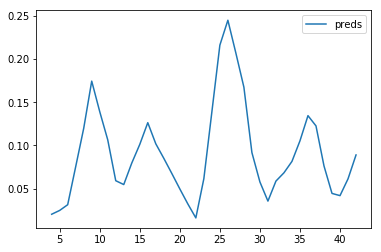

In [14]:
import matplotlib.image as mpimg
import glob

prefix = '527437885'
# prefix = '534365178'
# prefix = '531286675'  # This video does not perform well. But the defect is also subtle.
folder = '/data/generated/val-all-videos/best/'

plt.figure(figsize=(20,20))
columns = 16

jpgs = glob.glob(folder + prefix + '-*.jpg')
imgs = np.asarray(list(map(load_image, jpgs)))

preds = model.predict(imgs)
df = pd.DataFrame(dict(preds=preds[:,1]))
df = df.rolling(5, win_type='triang').mean()
df.plot()

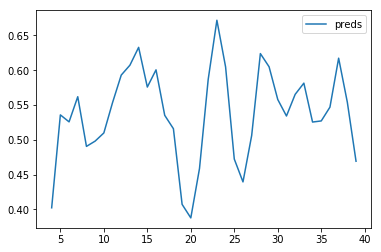

In [15]:
folder = '/data/generated/val-all-videos/worst/'
jpgs = glob.glob(folder + prefix + '-*.jpg')
imgs = np.asarray(list(map(load_image, jpgs)))

preds_bad = model.predict(imgs)
df = pd.DataFrame(dict(preds=preds_bad[:,1]))
df = df.rolling(5, win_type='triang').mean()
df.plot()